In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import seaborn as sns
from tqdm import tqdm
from operator import itemgetter
from google.colab import drive
import os 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/QRT')

def weighted_accuracy(y_test, y_pred):
    y_abs = np.abs(y_test)
    norm = y_abs.sum()
    score = ((np.sign(y_pred) == np.sign(y_test)) * y_abs).sum() / norm
    return score


Mounted at /content/drive


In [ ]:
df_X = pd.read_csv('X_train_itDkypA.csv')
df_Y = pd.read_csv('/content/drive/MyDrive/QRT/y_train_3LeeT2g.csv')
df_supp = pd.read_csv('/content/drive/MyDrive/QRT/supplementary_data_Vkoyn8z.csv')
df_sub = pd.read_csv('/content/drive/MyDrive/QRT/random_submission_clean.csv')
df_X_test = pd.read_csv('/content/drive/MyDrive/QRT/X_test_Beg4ey3.csv')

In [ ]:
df = pd.concat([df_X.set_index('ID'),df_Y.set_index('ID')],axis='columns')
df.fillna(0,inplace=True)
df['TARGET'] = (df['RET_TARGET']>0).astype(int)
ret_cols = [x for x in df.columns if 'RET_' in x][:-1]
df.rename(columns={'ID_TARGET':'ID_asset'},inplace=True)
df.groupby('ID_DAY').mean()[ret_cols]

,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,RET_15,RET_150,RET_229,RET_121,RET_156,RET_57,RET_203,RET_264,RET_58,RET_224,RET_30,RET_159,RET_236,RET_261,RET_88,RET_59,RET_242,RET_116,RET_84,RET_240,RET_97,RET_0,RET_256,RET_263,RET_40,RET_184,RET_105,RET_49,RET_99,RET_26,RET_262,RET_187,...,RET_87,RET_148,RET_266,RET_248,RET_55,RET_66,RET_74,RET_259,RET_37,RET_245,RET_222,RET_138,RET_31,RET_118,RET_181,RET_56,RET_250,RET_115,RET_18,RET_270,RET_213,RET_232,RET_275,RET_285,RET_83,RET_47,RET_265,RET_296,RET_276,RET_255,RET_108,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297
ID_DAY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1177,0.008451,-0.022536,0.000921,0.000000,-0.011449,-0.026118,0.017299,0.025162,0.008490,-0.007358,0.018019,-0.028363,-0.020402,0.050070,0.009365,0.045976,-0.011118,-0.004043,0.011370,-0.013752,0.022135,-0.015627,-0.042268,0.002903,0.005273,-0.002684,0.024428,0.005753,0.007041,-0.052450,0.001248,0.000000,0.024030,0.009553,-0.016679,-0.023205,0.000280,-0.010977,0.072433,-0.001589,...,0.049493,0.016044,-0.016664,0.003994,0.020780,-0.013018,-0.004836,-0.027976,-0.019894,0.004633,0.022404,-0.015339,0.034004,0.027946,0.012966,-0.003556,-0.001898,-0.030170,0.000000,-0.015926,-0.000239,-0.024202,0.034142,-0.019343,-0.017429,0.000000,0.031829,0.000000,-0.015754,0.076285,-0.005159,0.048748,-0.001091,-0.013944,0.038879,0.069812,-0.018361,-0.007535,-0.021744,-0.019314
1178,-0.000215,-0.019511,0.013770,0.006188,-0.010647,-0.006377,0.004528,-0.017513,0.010504,0.000295,0.006326,-0.002636,-0.019420,-0.005336,-0.013458,0.004888,-0.000133,-0.003522,-0.017711,-0.015193,-0.021650,-0.032761,-0.019272,-0.017539,-0.013169,0.002626,0.000822,-0.007933,-0.011432,-0.019502,-0.007739,-0.005922,-0.001826,-0.027702,0.011544,0.019437,-0.009984,0.009730,0.016829,0.000114,...,-0.003519,-0.015180,-0.011879,-0.009322,0.003083,-0.014744,0.002591,-0.008445,-0.010974,0.006373,-0.005184,-0.000527,0.013930,-0.007668,-0.002938,0.016582,-0.010604,-0.006220,0.007653,0.002718,-0.012580,-0.007635,0.004557,-0.008563,-0.025083,0.006445,-0.010368,-0.053006,0.005777,0.020546,0.017695,0.000864,-0.013908,-0.027602,-0.004566,0.003633,-0.002920,-0.006048,-0.023022,0.004330
1179,-0.010475,0.002141,-0.008222,0.002015,0.015872,0.061849,0.036626,-0.003602,0.001542,-0.011045,-0.005072,-0.008684,-0.008758,0.004430,0.021905,-0.016587,-0.007795,0.025932,-0.013403,-0.005275,-0.003817,0.022153,0.000122,-0.002236,0.006406,0.001352,0.010991,0.011876,-0.004488,-0.004401,-0.022343,0.036275,-0.002877,-0.015587,0.014980,-0.012169,0.019287,-0.018257,0.001521,-0.005910,...,-0.001855,-0.005387,-0.005812,0.032742,-0.002223,-0.011407,-0.002371,-0.014312,-0.019787,-0.021221,0.031939,0.017078,-0.009846,-0.004061,-0.009045,-0.009649,-0.000356,0.001506,-0.005623,-0.027130,-0.017034,-0.024947,-0.004763,-0.007975,0.000015,0.000104,-0.002105,-0.007754,-0.027186,-0.038377,-0.002462,-0.006731,-0.002746,-0.021755,-0.013364,0.013387,0.010614,-0.004450,0.023363,-0.023733
1180,-0.050864,-0.064707,-0.041157,-0.053576,-0.044662,-0.052897,-0.050643,-0.042450,-0.055511,-0.047774,-0.047965,0.004361,-0.038452,-0.060308,-0.036578,-0.024606,-0.047605,-0.061277,-0.053805,-0.070105,-0.005515,-0.056221,0.000000,-0.032119,0.000000,-0.050006,-0.048831,-0.036347,-0.052799,-0.060973,-0.063848,-0.036090,-0.054211,-0.059914,-0.036691,0.027394,-0.019758,-0.050812,0.000190,-0.053840,...,-0.040414,-0.034091,-0.031880,-0.047472,-0.048976,0.000000,-0.047393,0.000000,-0.032419,-0.041707,-0.020631,-0.019273,-0.054264,-0.051213,-0.011443,-0.032304,-0.059680,-0.050779,-0.021622,-0.050198,-0.030327,-0.047844,-0.038119,0.012729,-0.010085,-0.029314,-0.022268,-0.028329,-0.023060,0.069503,0.005699,0.000000,-0.040274,-0.041833,-0.054312,-0.010934,-0.022274,-0.030483,-0.045054,-0.056725
1181,-0.000420,0.029366,-0.013195,-0.016901,0.005373,0.048812,0.012247,-0.000663,0.000000,0.015282,0.002909,0.001390,-0.000076,0.018345,-0.000477,-0.002240,0.000342,0.

Explained component ratios :  [0.25065755 0.02339824 0.02214029 0.01849177 0.01691793 0.01606939
 0.01501126 0.01372088 0.01298341 0.0124581 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


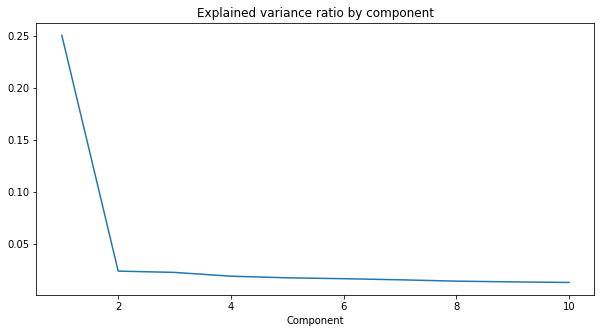

In [ ]:
pca = PCA(n_components=10)
pca.fit(df.groupby('ID_DAY').mean()[ret_cols])
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,11),pca.explained_variance_ratio_)
ax.set_title('Explained variance ratio by component')
ax.set_xlabel('Component')
fig.show()

components = df[ret_cols].dot(pca.components_.T)
components.columns = [f'PC_{i}' for i in range(1,11)]
df = pd.concat([df,components],axis='columns')

PC_cols =  [f'PC_{i}' for i in range(1,11)]
class_cols = [f'CLASS_LEVEL_{i}' for i in range(1,5)]
# df_lm = df[PC_cols + ['RET_TARGET'] + class_cols]
df_lm = df[PC_cols + ['RET_TARGET']]
df_lm['ID_TARGET'] = df_X['ID_TARGET'] 
print('Explained component ratios : ',pca.explained_variance_ratio_)

Fitting LR: 100%|██████████| 100/100 [00:02<00:00, 37.87it/s]


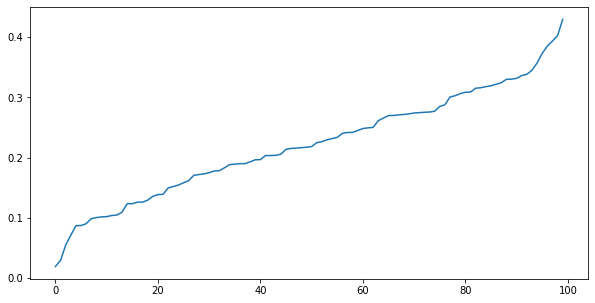

In [ ]:
#Regress (individually) illiquid stocks against 10 first principal components and rank them by R2 score 

scores = {ID : 0 for ID in df_lm['ID_TARGET'].unique()}
comp_col = components.columns
LR_models = {ID:LinearRegression() for ID in df_lm['ID_TARGET'].unique()}

for ID in tqdm(scores.keys(),desc='Fitting LR'):

  X, y  = df_lm[comp_col].loc[df_lm['ID_TARGET'] == ID] , df_lm['RET_TARGET'].loc[df_lm['ID_TARGET'] == ID]
  LR_models[ID].fit(X,y)
  scores[ID] = LR_models[ID].score(X,y)

fig, ax = plt.subplots(figsize=(10,5))
scores = np.array(sorted(scores.items(),key=itemgetter(1)))
r2_quantiles = np.quantile(scores[:,1],[0.5,0.25,0.5,0.75,0.95])
ax.plot(np.array(scores)[:,1])
fig.show()

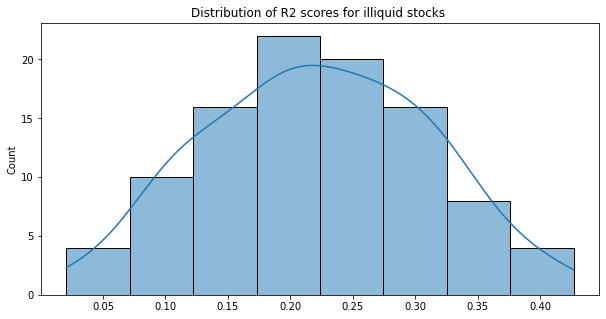

In [ ]:
fig, ax  = plt.subplots(figsize=(10,5))
sns.histplot(scores[:,1],ax=ax,kde=True)
ax.set_title('Distribution of R2 scores for illiquid stocks ')
fig.show()

In [ ]:
# Get subsectors by depth 

subsectors_depth_4 = np.unique(df_supp.drop('ID_asset',axis='columns'),axis=0)
subsectors_depth_3 = np.unique(df_supp.drop('ID_asset',axis='columns').values[:,:-1],axis=0)
subsectors_depth_2 = np.unique(df_supp.drop('ID_asset',axis='columns').values[:,:-2],axis=0)

subdict_depth_4 = {tuple(subsectors_depth_4[i]) : i for i in range(len(subsectors_depth_4))}
subdict_depth_3 = {tuple(subsectors_depth_3[i]) : i for i in range(len(subsectors_depth_3))}
subdict_depth_2 = {tuple(subsectors_depth_2[i]) : i for i in range(len(subsectors_depth_2))}

df_depth_4 = df_supp[df_supp.columns[1:]].apply(lambda arr: subdict_depth_4[tuple(arr)],axis=1)
df_depth_3 = df_supp[df_supp.columns[1:-1]].apply(lambda arr: subdict_depth_3[tuple(arr)],axis=1)
df_depth_2 = df_supp[df_supp.columns[1:-2]].apply(lambda arr: subdict_depth_2[tuple(arr)],axis=1)

df_depth = pd.concat([df_depth_2,df_depth_3,df_depth_4],axis='columns').rename(columns={0:'DEPTH_2',1:'DEPTH_3',2:'DEPTH_4'})
df_supp_depth = pd.concat([df_supp[['ID_asset','CLASS_LEVEL_1']],df_depth],axis='columns').rename(columns={'CLASS_LEVEL_1':'DEPTH_1'})

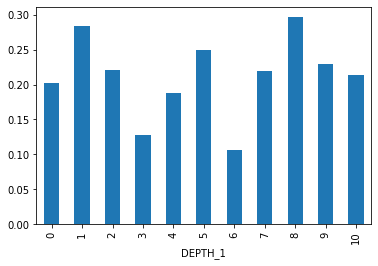

In [ ]:
df_f = pd.merge(df,df_supp_depth,on='ID_asset',how='inner')
tar_supp = df_supp_depth.loc[df_supp_depth['ID_asset'].isin(df_f['ID_asset'].unique())].copy()
scores_dict = dict(scores)
tar_supp['R2_score'] = tar_supp['ID_asset'].astype(float).apply(lambda u : scores_dict[u])
tar_supp.groupby('DEPTH_1').median()['R2_score'].plot(kind='bar')

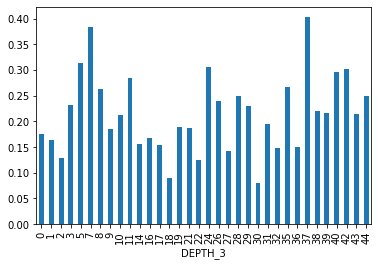

In [ ]:
tar_supp.groupby('DEPTH_3').mean()['R2_score'].plot(kind='bar')

In [ ]:
test_comp = df_X_test[ret_cols].fillna(0).dot(pca.components_.T).rename(columns={i:f'PC_{i+1}' for i in range(10)})
X_test = pd.concat([df_X_test,test_comp],axis='columns')
X_test['PRED_TARGET'] = np.nan

for ID in tqdm(X_test['ID_TARGET'].unique(),desc='pred'):
  model = LR_models[ID]
  pred = model.predict(X_test.loc[X_test['ID_TARGET']==ID][comp_col])
  X_test.loc[X_test['ID_TARGET']==ID,'PRED_TARGET'] = pred

X_test['RET_TARGET'] = 2*(X_test['PRED_TARGET']>0)-1

pred: 100%|██████████| 100/100 [00:00<00:00, 125.17it/s]


Let's have a look at the stability of the eigenvalues in random sample PCA:

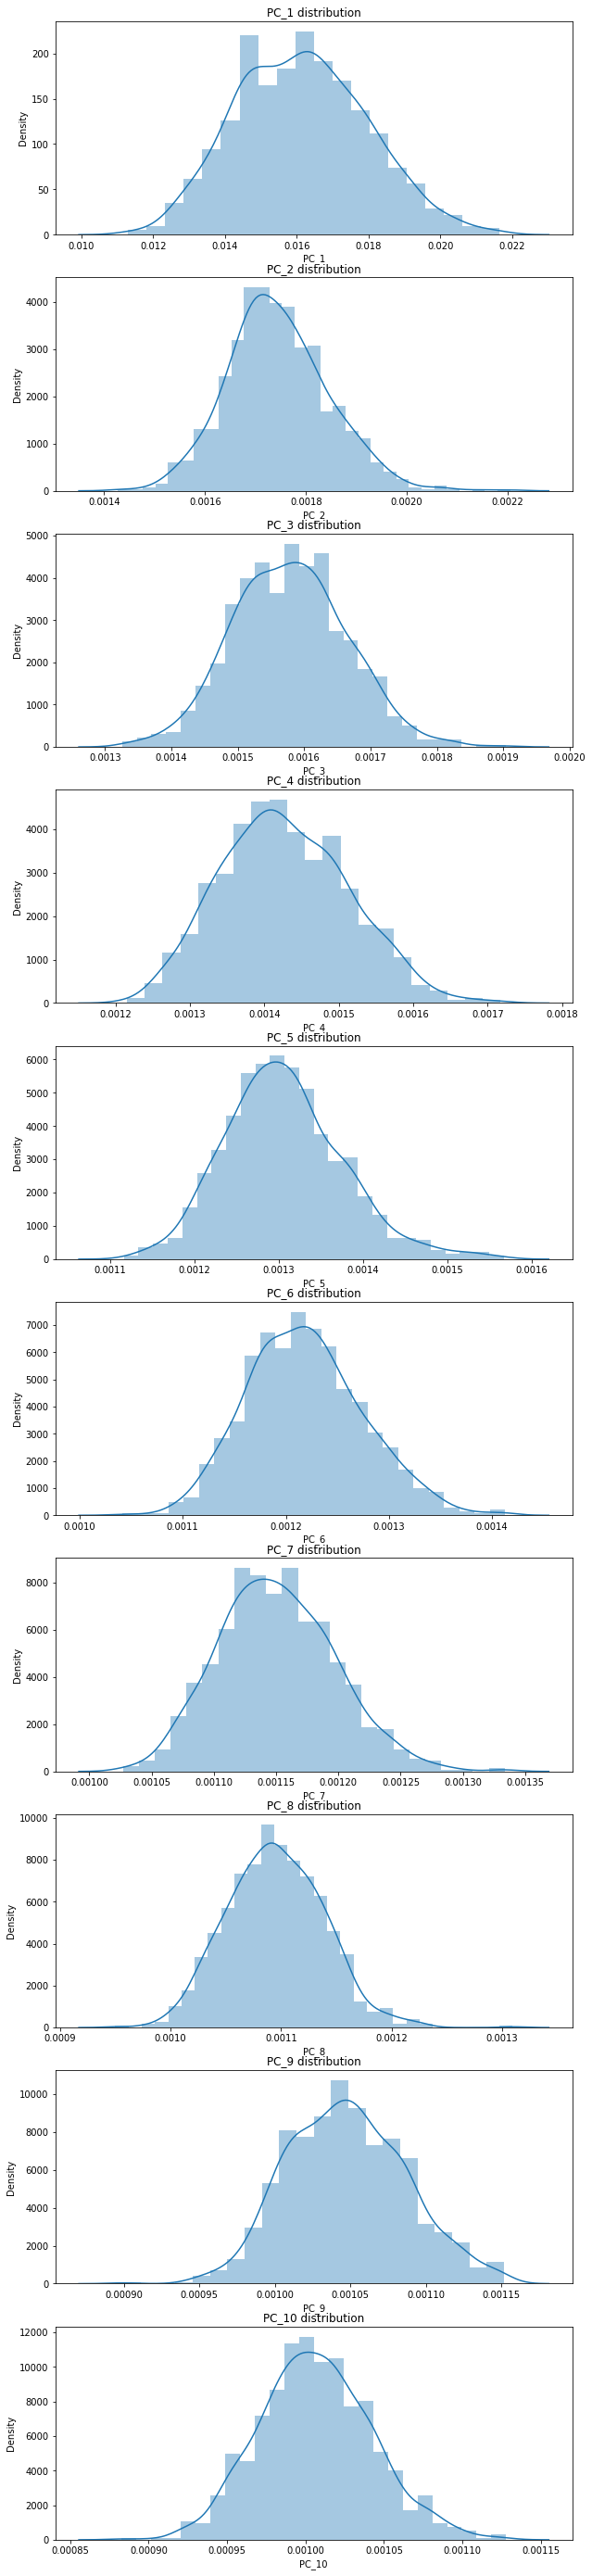

In [ ]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

n_samples = 1000
sample_pct  = 0.75
sample_size = 500
pca_dict = {i:PCA(n_components=10) for i in range(n_samples)}
unique_ids = df['ID_DAY'].unique()

for i in range(n_samples):
  X = df.groupby('ID_DAY').mean()[ret_cols]
  idx_samples  = np.random.choice(unique_ids,size=sample_size,replace=False)
  X_sample = X.iloc[X.index.isin(idx_samples)]
  pca_dict[i].fit(X_sample)

df_comp_samples = pd.DataFrame(np.array([pca_dict[i].explained_variance_ for i in range(n_samples)]),columns=comp_col)
fig,ax = plt.subplots(figsize=(10,5*10),nrows=10)
for i in range(1,11):
  sns.distplot(df_comp_samples[f'PC_{i}'],kde=True,ax=ax[i-1])
  ax[i-1].set_title(f'PC_{i} distribution')

In [ ]:
# get train indices : all different liquid assets have to be taken in train and test in equal proportions.
# get mean weighted accuracy for PCA10 model by asset (mean over random train/test splits)

import warnings
warnings.filterwarnings('ignore')
pct = 0.7

ACC = {ID:[] for ID in df['ID_asset'].unique()}
n_iter = 400

for N in tqdm(range(n_iter),desc='TTS'):
  train_indices = []
  for ID in df['ID_asset'].unique():
    size = int(pct*len(df[df['ID_asset'] == ID]))
    asset_idx = np.random.choice(df[df['ID_asset'] == ID].index,replace=False,size=size)
    train_indices.append(asset_idx)

  train_indices = np.concatenate(train_indices)

  df_train,df_test = df.iloc[train_indices], df[~df.index.isin(train_indices)]
  pca_ = PCA(n_components=10)
  pca_.fit(df_train.groupby('ID_DAY').mean()[ret_cols])
  df_comp = df_train[ret_cols].dot(pca_.components_.T).rename(columns={i:f'PC_{i+1}' for i in range(10)})
  df_comp = pd.concat([df_comp,df_train[['ID_asset','RET_TARGET']]],axis='columns')
  df_test.loc[:,comp_col] =  df_test[ret_cols].dot(pca_.components_.T).rename(columns={i:f'PC_{i+1}' for i in range(10)})

  LR  = {ID:LinearRegression() for ID in df['ID_asset'].unique()}

  for ID in LR.keys():
    LR[ID].fit(df_comp.drop(['ID_asset','RET_TARGET'],axis='columns').loc[df_comp['ID_asset']==ID],df_comp['RET_TARGET'].loc[df_comp['ID_asset']==ID])
    df_test.loc[df_test['ID_asset'] == ID,'PRED_RETURN'] = LR[ID].predict(df_test.loc[df_test['ID_asset']==ID,comp_col])
    ACC[ID].append(weighted_accuracy(df_test.loc[df_test['ID_asset'] == ID,'RET_TARGET'],df_test.loc[df_test['ID_asset'] == ID,'PRED_RETURN']))

mean_acc = {key:np.mean(ACC[key]) for key in ACC.keys()}
mean_acc  = sorted(mean_acc.items(),key=itemgetter(1))
df_acc = pd.DataFrame(np.array(mean_acc))
df_acc.loc[:,0] = df_acc.loc[:,0].astype(int)
df_acc.rename(columns={0:'ID_asset',1:'ACC_SCORE'},inplace=True)
df_acc = pd.merge(df_acc,df_supp_depth,on='ID_asset',how='inner')
df_acc['ACC_SCORE_BIN'] = pd.qcut(df_acc['ACC_SCORE'],q=5,labels=False)


In [ ]:
#Implement all with a proper pipeline 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer
from tqdm import tqdm 

X_train, y_train = df_X, df_Y.drop('ID',axis='columns')
sectors_dict=dict(df_supp[['ID_asset','CLASS_LEVEL_1']].values)

#Transformer 1 : PCA on (unique ID_day rows) predictor asset returns

class PCATransformer(BaseEstimator,TransformerMixin):
  def __init__(self,n_components=10):
    self.n_components = n_components
    self.PCA_model = PCA(n_components=self.n_components)
    self.ret_cols = []
  def fit(self,X,y=None):
    assert isinstance(X,pd.DataFrame)
    self.ret_cols = [x for x in X.columns if 'RET_' in x]
    #~Groupby the return by their ID_DAY, Rescale and apply PCA
    X_scaled = StandardScaler().fit_transform(X.groupby('ID_DAY').mean()[self.ret_cols].fillna(0))
    self.PCA_model.fit(X_scaled)
    return self
  def transform(self,X,y=None):
    #Return projection of data on the n_components components
    PC_df = X[self.ret_cols].fillna(0).dot(self.PCA_model.components_.T).rename(columns={i:f'PC_{i+1}' for i in range(10)})
    return PC_df

#Transformer2 : Build depth 1 & depth 2 spreads

class SectorialMeansTransformer(BaseEstimator,TransformerMixin):
  def __init__(self,sectors_dict):
    self.sectors_dict = sectors_dict
  def fit(self,X,y=None):
    assert(isinstance(X,pd.DataFrame)), 'X should be an instance of pd.DataFrame'
    return self
  def transform(self,X,y=None):
    X_out = pd.DataFrame(index=X.index)
    ret_cols = [x for x in X.columns if 'RET_' in x]
    for sector in sectors_dict.values():
      sector_mean =  X.loc[:,[x for x in ret_cols if self.sectors_dict[int(x.split('_')[1])] == sector]].mean(axis=1)
      X_out.loc[:,f'mean_sector_{sector}'] = sector_mean
    return X_out 

#Transformer3 : Select ID_asset column

class ColumnSelector(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    if not isinstance(cols, list):
      self.cols = [cols]
    else:
      self.cols = cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    return X.loc[:,self.cols]

#Multi output regression by asset (adapted to the data challenge format)

class CustomMultiLinearRegression(BaseEstimator,RegressorMixin):
  def __init__(self):
    pass
  def fit(self,X,y):
    #X : type : np.array with last column = target ID
    if isinstance(y,pd.DataFrame): 
      y = y.values
    #y : type : np.array with returns of target ID
    self.regressors = {x : LinearRegression() for x in np.unique(X[:,-1])}

    for key in tqdm(self.regressors.keys()):
      X_fit, y_fit = X[X[:,-1] == key][:,:-1], y[X[:,-1] == key]
      self.regressors[key].fit(X_fit,y_fit)

  def predict(self,X):
    y_pred = np.empty(shape=(X.shape[0],1))
    for ID in np.unique(X[:,-1]):
      y_pred[X[:,-1]==ID] = self.regressors[ID].predict(X[X[:,-1]==ID][:,:-1])
    return y_pred

#Multi output LGBM by asset (adapted to the data challenge format)

class CustomLGBMRegression(BaseEstimator,RegressorMixin):
  def __init__(self,learning_rate=10e-3,n_estimators=50,max_depth=5,class_weight=None):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.class_weight = class_weight

    pass
  def fit(self,X,y):
    #X : type : np.array with last column = target ID
    if isinstance(y,pd.DataFrame): 
      y = y.values
    #y : type : np.array with returns of target ID
    self.regressors = {x : LGBMClassifier(n_estimators=self.n_estimators,
                                          learning_rate = self.learning_rate,
                                          max_depth = self.max_depth,
                                          class_weight=self.class_weight) for x in np.unique(X[:,-1])}

    for key in tqdm(self.regressors.keys()):
      X_fit, y_fit = X[X[:,-1] == key][:,:-1], np.sign(y[X[:,-1] == key])
      self.regressors[key].fit(X_fit,y_fit)

  def predict(self,X):
    y_pred = np.empty(shape=(X.shape[0],1))
    for ID in np.unique(X[:,-1]):
      y_pred[X[:,-1]==ID] = self.regressors[ID].predict(X[X[:,-1]==ID][:,:-1]).reshape(len(y_pred[X[:,-1]==ID]),1)
    return y_pred

# Return nb_folds random splits , each split sampling  size / 1-size 
# Custom -> each fold samples an equal number of samples for each unique ID_TARGET (this way all the asset are sampled in train/test)

class CustomLassoRegression(BaseEstimator,RegressorMixin):
  def __init__(self,learning_rate=10e-3,n_estimators=50,max_depth=5,class_weight=None):
    self.n_estimators = n_estimators
    self.learning_rate = learning_rate
    self.max_depth = max_depth
    self.class_weight = class_weight

    pass
  def fit(self,X,y):
    #X : type : np.array with last column = target ID
    if isinstance(y,pd.DataFrame): 
      y = y.values
    #y : type : np.array with returns of target ID
    self.regressors = {x : LGBMClassifier(n_estimators=self.n_estimators,
                                          learning_rate = self.learning_rate,
                                          max_depth = self.max_depth,
                                          class_weight=self.class_weight) for x in np.unique(X[:,-1])}

    for key in tqdm(self.regressors.keys()):
      X_fit, y_fit = X[X[:,-1] == key][:,:-1], np.sign(y[X[:,-1] == key])
      self.regressors[key].fit(X_fit,y_fit)

  def predict(self,X):
    y_pred = np.empty(shape=(X.shape[0],1))
    for ID in np.unique(X[:,-1]):
      y_pred[X[:,-1]==ID] = self.regressors[ID].predict(X[X[:,-1]==ID][:,:-1]).reshape(len(y_pred[X[:,-1]==ID]),1)
    return y_pred

# Return nb_folds random splits , each split sampling  size / 1-size 
# Custom -> each fold samples an equal number of samples for each unique ID_TARGET (this way all the asset are sampled in train/test)

def CustomCVFolds(df,size=0.7,nb_folds=10):

  ids, idx = df[['ID_TARGET']].copy(), df[['ID_TARGET']].index
  uniques = ids['ID_TARGET'].unique()
  train_folds, test_folds = [], []

  for n in range(nb_folds):
    local_fold = []
    for id in uniques:
      id_index = ids[ids['ID_TARGET']==id].index
      id_train_indices = np.random.choice(id_index,size=int(len(id_index)*size),replace=False)
      local_fold.append(id_train_indices)
    
    local_fold = np.concatenate(local_fold)
    train_folds.append(local_fold)
    test_folds.append(np.array(ids[~ids.index.isin(local_fold)].index))

  #CV expects an iterator
  return zip(train_folds,test_folds)


In [ ]:
#Define the custom folds

cv_folds = CustomCVFolds(df_X,size=0.7,nb_folds=100)
custom_scorer = make_scorer(weighted_accuracy)
#Create the Pipelines for lgbmreg
pipe_linreg = Pipeline(steps=[('union',FeatureUnion([('pca_transform',PCATransformer()),
                                              ('id_col_selector',ColumnSelector(cols=['ID_TARGET']))])),   
                       ('reg',CustomMultiLinearRegression())
                       ])

pipe_lgbmreg = Pipeline(steps=[('union',FeatureUnion([('pca_transform',PCATransformer()),
                                              ('id_col_selector',ColumnSelector(cols=['ID_TARGET']))])),   
                       ('reg',CustomLGBMRegression())
                       ])

params_linreg = {'union__pca_transform__n_components':[1,4,7,10,50]}
grid_search_linreg = GridSearchCV(pipe_linreg, params_linreg, n_jobs=-1, verbose=1,cv=cv_folds,scoring=custom_scorer)

params_lgbmreg = {'union__pca_transform__n_components':[1,4,7],
                  'reg__n_estimators':[10,50,100,300],
                  'reg__max_depth':[2,4,7,10],
                  'reg__class_weight':[None,'balanced']}

grid_search_lgbmreg = GridSearchCV(pipe_lgbmreg, params_lgbmreg, n_jobs=-1, verbose=1,cv=cv_folds,scoring=custom_scorer)

In [ ]:
grid_search_linreg.fit(X_train,y_train)

Fitting 100 folds for each of 4 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  5.5min finished
100%|██████████| 100/100 [00:00<00:00, 155.97it/s]


GridSearchCV(cv=<zip object at 0x7f11d6d04dc0>, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('pca_transform',
                                                                        PCATransformer(n_components=10)),
                                                                       ('id_col_selector',
                                                                        ColumnSelector(cols=['ID_TARGET']))],
                                                     transformer_weights=None,
                                                     verbose=False)),
                                       ('reg', CustomMultiLinearRegression())],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'union__pca_transform__n_components

In [ ]:
grid_search_linreg.best_score_

0.7297702977455708